In [1]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd

# Parametric Analysis
This notebook performs a parametric analysis of a building design using EnergyPlus and BESOS helper functions.  
We load a model from **test.idf**, define parameters to vary, set objectives,then run the model for a signle parameter and finaly all parameter combinations and plot the results.

### Various Imports
`EvaluatorEP` manages energy-plus simulations for a single problem.  
Problems, like `EPProblem` organise several parameters together.  
Parameters, like `Parameter` describe a single variable for the building.
They are composed of a `Descriptor` and a `Selector`.


In [30]:
building = ef.get_building('/home/ict4bd/prova_8.idf')

Let's check what materials are in the model.  


In [31]:
[materials.Name for materials in building.idfobjects["MATERIAL"]]# get a list of the Name property of all IDF objects of class MATERIAL


['Urea Formaldehyde Foam_00171',
 'Cast Concrete_01',
 'Floor/Roof Screed_007',
 'Timber Flooring_003',
 'Asphalt 1_001',
 'MW Glass Wool (rolls)_00245',
 'Plasterboard_0013',
 'Gypsum Plasterboard_0025',
 'Brickwork Outer_01',
 'XPS Extruded Polystyrene  - CO2 Blowing_0041',
 'Concrete Block (Medium)_01',
 'Gypsum Plastering_0013']

# Building Parameters with Selectors

`Selectors` identify which part of the building model to modify, and how to modify it.  

## Field Selectors
`FieldSelector`s modify individual fields in a building model.  


The example building loaded here contains a `Material` class object named `XPS Extruded Polystyrene  - CO2 Blowing_0041` which has a `Thickness` field.  
We make a selector that modifies this insulation thickness.

In [32]:
insulation = FieldSelector(class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_0041', field_name='Thickness')

There is only one object in the example building with the name `XPS Extruded Polystyrene  - CO2 Blowing_0041`, so we can ommit the `class_name`.  
The building will be searched for any object with the correct `object_name`. However `flied_name` is mandatory.

If you have multiple objects of the same type that all share the same field to modify, set `object_name` to `'*'`.

In [33]:
[materials for materials in building.idfobjects["LIGHTS"]]# get a list of the Name property of all IDF objects of class MATERIAL


[
 Lights,
     Block1:ZoneWest,          !- Name
     Block1:ZoneWest,          !- Zone or ZoneList Name
     Office_OpenOff_Light,     !- Schedule Name
     Watts/Area,               !- Design Level Calculation Method
     ,                         !- Lighting Level
     20,                       !- Watts per Zone Floor Area
     ,                         !- Watts per Person
     0,                        !- Return Air Fraction
     0.42,                     !- Fraction Radiant
     0.18,                     !- Fraction Visible
     1,                        !- Fraction Replaceable
     ;                         !- EndUse Subcategory, 
 Lights,
     Block1:ZoneSouth,         !- Name
     Block1:ZoneSouth,         !- Zone or ZoneList Name
     Office_OpenOff_Light,     !- Schedule Name
     Watts/Area,               !- Design Level Calculation Method
     ,                         !- Lighting Level
     20,                       !- Watts per Zone Floor Area
     ,                     

In [34]:
lights = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')

## Parameter scripts using a Generic Selector

Parameters can also be created by defining a function that takes an idf and a value and mutates the idf. These functions can be specific to a certain idf's format, and can perform any arbitrary transformation. Creating these can be more involved.  
`eppy_funcs` contains the functions `one_window` and `wwr_all`. `one_window` removes windows from a building untill it has only one per wall. `wwr_all` takes a building with one window per wall and adjusts it to have a specific window to wall ratio.

BESOS also includes some pre-defined parameter scripts:
+ `wwr(Range)` for window to wall ratio  

Here we define the WWR of all walls in the model to be between 10% and 90%.


In [35]:
window_to_wall = wwr(RangeParameter(0.1,0.9)) # use a special shortcut to get the window-to-wall parameter

## EvaluatorEP
The EnergyPlus evaluator needs a problem with parameters that can modify it, objectives to report, and a building model.  
A problem (`problem = parameters + objectives`) can be easily applied to any building model (`evaluator = problem + building`).

### Problems
`Problem` objects represent inputs and outputs.  
We have defined various inputs using `parameters` above, and we define objectives of heating and cooling use.

In [36]:
insulation = FieldSelector(class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_0041', field_name='Thickness')
parameters = [Parameter(selector=insulation,name='Insulation Thickness')] 
parameters

[Parameter(name='Insulation Thickness', selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_0041'))]

Now we have to define the `objectives` and problem

In [37]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`
problem=EPProblem(parameters, objectives) # problem = parameters + objectives
problem

EPProblem(inputs=[Parameter(name='Insulation Thickness', selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_0041'))], outputs=[MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f2523583a60>, key_name='Electricity:Facility'), MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f2523583a60>, key_name='DistrictHeating:Facility'), MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f2523583a60>, key_name='DistrictCooling:Facility')], minimize_outputs=[True, True, True], converters={'outputs': <class 'objectives.MeterReader'>, 'constraints': <class 'objectives.MeterReader'>})

In [38]:
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir' ,epw_file='/home/ict4bd/ipython/weather/my_epw_file.epw') # evaluator = problem + building

Now we run the evaluator with wall insulation thickness set to 0.5m 

In [39]:
result = evaluator([0.5]) 
values = dict(zip(objectives, result))
for key, value in values.items():
    print(key, " :: ", "{0:.2f}".format(value/3.6e6), "kWh")

Electricity:Facility  ::  21320.28 kWh
DistrictHeating:Facility  ::  7186.75 kWh
DistrictCooling:Facility  ::  19368.31 kWh


In [12]:
result = evaluator([1]) 
values = dict(zip(objectives, result))
for key, value in values.items():
    print(key, " :: ", "{0:.2f}".format(value/3.6e6), "kWh")

Electricity:Facility  ::  21320.28 kWh
DistrictHeating:Facility  ::  7172.79 kWh
DistrictCooling:Facility  ::  10510.66 kWh


# Descriptors

Descriptors specify what kinds of values are valid for a parameter.  
There are currently, two variants: `RangeParameter` and `CategoryParameter`.  


`RangeParameter` is a descriptor that indicates a parameter that can take on values from an interval.  
`CategoryParameter` is a descriptor that indicates a paramter that can take on values from a list.

### RangeParameters 
$min \leq x \leq max$

In [13]:
zero_to_one_exclusive = RangeParameter(min_val = 0.01, max_val=0.99)

### CategoryParameters 
A list of options.

In [14]:
text_example = CategoryParameter(options=['a', 'b', 'c', 'other'])
single_digit_integers = CategoryParameter(options=range(10))

We can combine this with the `Selector` above to get a `Parameter`:

In [15]:
insulation = FieldSelector(class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_0041', field_name='Thickness')

insulation_param = Parameter(selector=insulation,
                                 value_descriptor=zero_to_one_exclusive,
                                 name='Insulation Thickness')
print(insulation_param)
parameters = [insulation_param] 


Parameter(name='Insulation Thickness', selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_0041'), value_descriptor=RangeParameter(min=0.01, max=0.99))


### Sampling
These descriptors can be used to make `Parameters`.  
Then we can generate samples.

In [16]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives

samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=2)
samples

,Insulation Thickness
0,0.918232
1,0.356506


In [17]:
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw_file='/home/ict4bd/ipython/weather/my_epw_file.epw')
outputs = evaluator.df_apply(samples, keep_input=True)

outputs

,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.918232,7.675301e+10,2.589071e+10,3.795298e+10
1,0.356506,7.675301e+10,2.668202e+10,3.819941e+10


In [18]:
[materials for materials in building.idfobjects["WINDOWMATERIAL:GLAZING"]]

[
 WindowMaterial:Glazing,
     3,                        !- Name
     SpectralAverage,          !- Optical Data Type
     ,                         !- Window Glass Spectral Data Set Name
     0.006,                    !- Thickness
     0.775,                    !- Solar Transmittance at Normal Incidence
     0.071,                    !- Front Side Solar Reflectance at Normal Incidence
     0.071,                    !- Back Side Solar Reflectance at Normal Incidence
     0.881,                    !- Visible Transmittance at Normal Incidence
     0.08,                     !- Front Side Visible Reflectance at Normal Incidence
     0.08,                     !- Back Side Visible Reflectance at Normal Incidence
     0,                        !- Infrared Transmittance at Normal Incidence
     0.84,                     !- Front Side Infrared Hemispherical Emissivity
     0.84,                     !- Back Side Infrared Hemispherical Emissivity
     0.9,                      !- Conductivity
   

In [19]:
more_parameters = expand_plist(
    # class_name is NOT provided
    #{'object_name':
    # {'field_name':(min, max)}}
    {'3':
     {'Conductivity':(0.1,1),
      'Solar Transmittance at Normal Incidence':(0.01,0.8)
     }
    })

In [20]:
parameters = [insulation_param] + more_parameters +[window_to_wall]

In [21]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives

samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=8)
samples

,Insulation Thickness,Conductivity,Solar Transmittance at Normal Incidence,Window to Wall Ratio
0,0.974546,0.760073,0.439303,0.779813
1,0.215824,0.185259,0.099899,0.114760
2,0.530790,0.458303,0.664158,0.657197
3,0.743445,0.898498,0.741451,0.340232
4,0.284121,0.628219,0.366024,0.292785
5,0.040528,0.422681,0.187577,0.507774
6,0.412781,0.885487,0.591679,0.831645
7,0.793565,0.311538,0.273386,0.471187


In [22]:
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw_file='/home/ict4bd/ipython/weather/my_epw_file.epw')
outputs = evaluator.df_apply(samples, keep_input=True)

outputs.describe()

,Insulation Thickness,Conductivity,Solar Transmittance at Normal Incidence,Window to Wall Ratio,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,8.000000,8.000000,8.000000,8.000000,8.000000e+00,8.000000e+00,8.000000e+00
mean,0.499450,0.568757,0.420435,0.499424,7.675301e+10,2.727770e+10,3.829021e+10
std,0.320193,0.266178,0.231048,0.248066,0.000000e+00,2.405402e+09,5.921127e+08
min,0.040528,0.185259,0.099899,0.114760,7.675301e+10,2.586075e+10,3.791917e+10
25%,0.267046,0.394896,0.251934,0.328370,7.675301e+10,2.611353e+10,3.794369e+10
50%,0.471786,0.543261,0.402663,0.489480,7.675301e+10,2.637496e+10,3.809472e+10
75%,0.755975,0.791426,0.609799,0.687851,7.675301e+10,2.704542e+10,3.829238e+10
max,0.974546,0.898498,0.741451,0.831645,7.675301e+10,3.310330e+10,3.969861e+10


In [23]:
outputs

,Insulation Thickness,Conductivity,Solar Transmittance at Normal Incidence,Window to Wall Ratio,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.974546,0.760073,0.439303,0.779813,7.675301e+10,2.586075e+10,3.794707e+10
1,0.215824,0.185259,0.099899,0.114760,7.675301e+10,2.735917e+10,3.836605e+10
2,0.530790,0.458303,0.664158,0.657197,7.675301e+10,2.621752e+10,3.804341e+10
3,0.743445,0.898498,0.741451,0.340232,7.675301e+10,2.612325e+10,3.793353e+10
4,0.284121,0.628219,0.366024,0.292785,7.675301e+10,2.694083e+10,3.826783e+10
5,0.040528,0.422681,0.187577,0.507774,7.675301e+10,3.310330e+10,3.969861e+10
6,0.412781,0.885487,0.591679,0.831645,7.675301e+10,2.653241e+10,3.814604e+10
7,0.793565,0.311538,0.273386,0.471187,7.675301e+10,2.608437e+10,3.791917e+10


Text(0, 0.5, 'DistrictCooling:Facility')

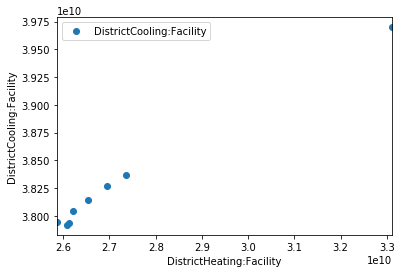

In [24]:
_ = outputs.plot(x=objectives[1], y=objectives[2], style = 'o')
plt.xlabel(objectives[1])
plt.ylabel(objectives[2])

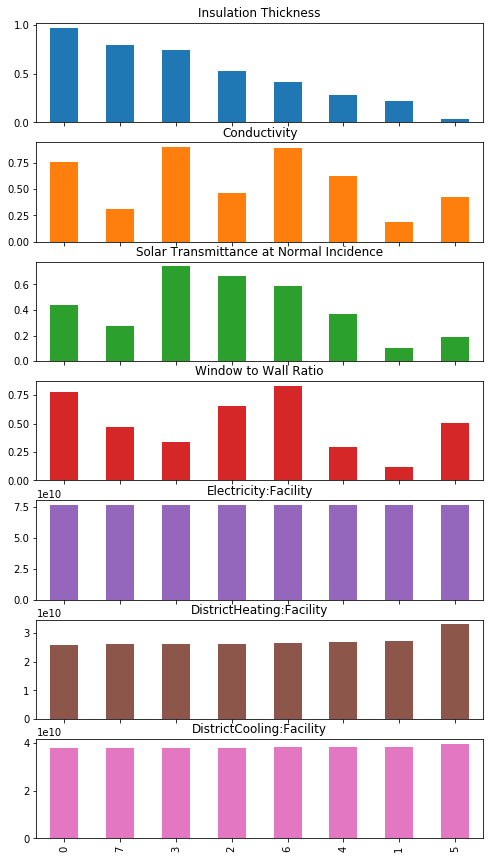

In [25]:
outputs = outputs.sort_values(by=objectives[1])
ax=outputs.plot.bar(subplots=True,legend=None, figsize=(8,15))

## Visualising the parametric analysis

A better way to analyse the results is by looking at scatter plots of the inputs versus the outputs.  
This enables us to visually see strong relationships of inputs and outputs.

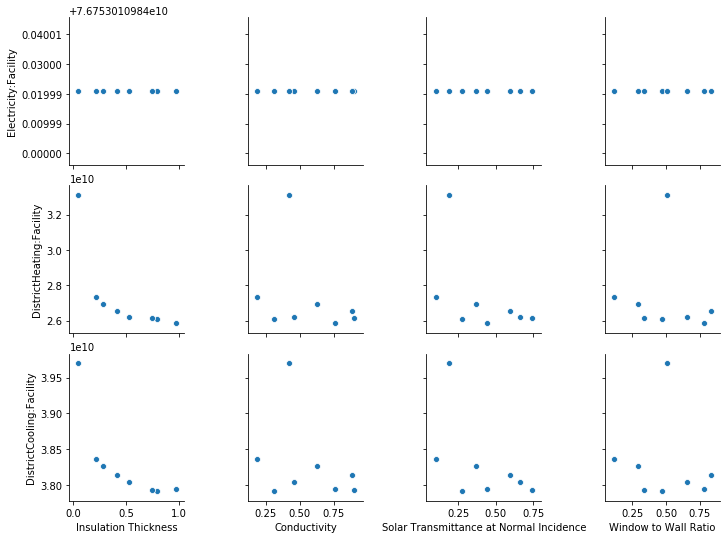

In [26]:
_=pairplot(outputs,x_vars=samples.columns, y_vars=objectives, kind="scatter")

### Correlation heat map
Another way to analyse the impact of the inputs on the outputs is by analysing the correlation.  
A common metric is the Pearsson correlation coefficient:

$ r = \frac{N\sum{XY}-(\sum{X}\sum{Y})}{\sqrt{ [N\sum{x^2}-(\sum{x})^2 ][N\sum{y^2}-(\sum{y})^2 }]} $

where N is the number of samples. $X$ is the vector of observation of variable 1 (e.g. wall conductivity) and $Y$ is the vetor of observations of variable 2 (e.g. electricity consumption).  
The closer $r$ is to one the stronger the correlation, and similarly for negative one and negative correleation.

To visualize the correlation coefficients of all inputs and outputs, we can plot a heatmap:

In [27]:
outputs.corr()

,Insulation Thickness,Conductivity,Solar Transmittance at Normal Incidence,Window to Wall Ratio,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Insulation Thickness,1.000000e+00,3.818105e-01,4.756684e-01,3.812562e-01,1.853377e-16,-7.231096e-01,-7.666558e-01
Conductivity,3.818105e-01,1.000000e+00,7.626210e-01,4.980934e-01,1.114742e-16,-3.047882e-01,-3.103321e-01
Solar Transmittance at Normal Incidence,4.756684e-01,7.626210e-01,1.000000e+00,4.643019e-01,4.334285e-16,-5.069451e-01,-5.245192e-01
Window to Wall Ratio,3.812562e-01,4.980934e-01,4.643019e-01,1.000000e+00,2.990333e-16,-1.215673e-01,-1.250516e-01
Electricity:Facility,1.853377e-16,1.114742e-16,4.334285e-16,2.990333e-16,1.000000e+00,2.119231e-16,1.721836e-15
DistrictHeating:Facility,-7.231096e-01,-3.047882e-01,-5.069451e-01,-1.215673e-01,2.119231e-16,1.000000e+00,9.958357e-01
DistrictCooling:Facility,-7.666558e-01,-3.103321e-01,-5.245192e-01,-1.250516e-01,1.721836e-15,9.958357e-01,1.000000e+00


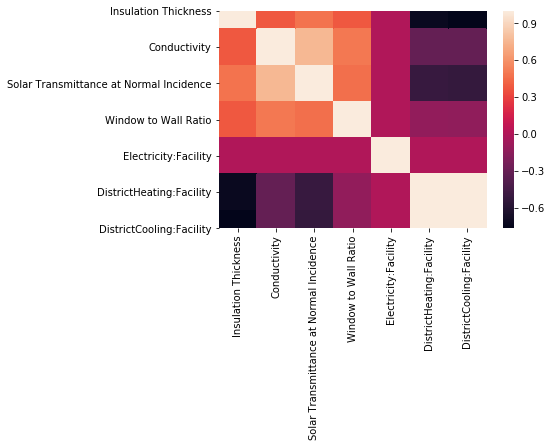

In [28]:
_ = heatmap(outputs.corr())

In [29]:
inputs = sampling.dist_sampler(sampling.full_factorial, problem, num_samples=5, level=2)
inputs

,Insulation Thickness,Conductivity,Solar Transmittance at Normal Incidence,Window to Wall Ratio
0,0.01,0.10,0.010,0.1
1,0.50,0.10,0.010,0.1
2,0.01,0.55,0.010,0.1
3,0.50,0.55,0.010,0.1
4,0.01,0.10,0.405,0.1
5,0.50,0.10,0.405,0.1
6,0.01,0.55,0.405,0.1
7,0.50,0.55,0.405,0.1
8,0.01,0.10,0.010,0.5
9,0.50,0.10,0.010,0.5
